# Introduction

I have been testing different nlp libraries and wanted to try some of their abilities on the quora question pair dataset. This notebook generates new sets of features that might be useful for classification modeling. First, spacy tags the parts of speech in the texts it parses, which can be made into a sparse matrix and joined to the original dataframe. The second item is a similarity score between texts, I thought the 1-similarity number would be more intuitive so created a function around spacy's method. Third, textblob generates a sentiment and subjectivity value that could have predictive value.

In [1]:
import pandas as pd
import spacy

In [2]:
train = pd.read_csv("./input/train.csv.zip")

In [3]:
train.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [4]:
train.shape

(404290, 6)

In [5]:
nlp = spacy.load("en")

## Parts of speech in spacy

In [6]:
def pos_count(string, num):
    #counts parts of speech for each spacy document object
    parsed_string = nlp(string)
    pos_dict = {}
    
    for word in parsed_string:
        if word.pos_ + str(num) in pos_dict:
            pos_dict[word.pos_ + str(num)] += 1
        else:    
            pos_dict[word.pos_ + str(num)] = 1
    return pos_dict    

In [7]:
print(train['question2'][5])
b = pos_count(train['question2'][5], 1)
print(b)

for word in nlp(train['question2'][5]):
    print(word, word.pos_)

I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
{'PROPN1': 4, 'ADP1': 2, 'PRON1': 2, 'PUNCT1': 4, 'NOUN1': 1, 'CONJ1': 1, 'ADJ1': 2, 'DET1': 2, 'VERB1': 3}
I PRON
'm VERB
a DET
triple ADJ
Capricorn PROPN
( PUNCT
Sun PROPN
, PUNCT
Moon PROPN
and CONJ
ascendant ADJ
in ADP
Capricorn PROPN
) PUNCT
What NOUN
does VERB
this DET
say VERB
about ADP
me PRON
? PUNCT


In [8]:


pos_list1 = []
for item in train['question1'][0:100]:
    pos_dict = pos_count(item, 1)
    pos_list1.append(pos_dict)

pos_list2 = []
for item in train['question2'][0:100]:
    pos_dict = pos_count(item, 2)
    pos_list2.append(pos_dict)

    

In [9]:
pos_df1 = pd.DataFrame(pos_list1).fillna(0)
pos_df2 = pd.DataFrame(pos_list2).fillna(0)

train_1000 = pd.concat([train[0:1000], pos_df1, pos_df2], axis = 1)

In [10]:
train_1000.head()

,id,qid1,qid2,question1,question2,is_duplicate,ADJ1,ADP1,ADV1,CONJ1,...,ADV2,CONJ2,DET2,NOUN2,NUM2,PART2,PRON2,PROPN2,PUNCT2,VERB2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.0,3.0,0.0,0.0,...,0.0,0.0,1.0,6.0,0.0,1.0,0.0,0.0,1.0,2.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.0,1.0,0.0,0.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,4.0,5.0,3.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1.0,2.0,1.0,0.0,...,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,4.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1.0,0.0,4.0,0.0,...,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,3.0,3.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,2.0,1.0,0.0,1.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,2.0


In [11]:
train_1000[['is_duplicate', 'PROPN1', 'PROPN2']].groupby('is_duplicate').describe()

PROPN1     PROPN2
is_duplicate                            
0            count  65.000000  65.000000
             mean    0.953846   0.661538
             std     1.575504   1.135739
             min     0.000000   0.000000
             25%     0.000000   0.000000
             50%     0.000000   0.000000
             75%     1.000000   1.000000
             max     7.000000   5.000000
1            count  35.000000  35.000000
             mean    0.942857   0.685714
             std     1.258918   1.105373
             min     0.000000   0.000000
             25%     0.000000   0.000000
             50%     1.000000   0.000000
             75%     1.000000   1.000000
             max     5.000000   4.000000

# Sentence similarity

In [12]:
def dis_similarity(question_pair):
    
    parsed1 = nlp(question_pair[0])
    parsed2 = nlp(question_pair[1])
    anti_sim = 1 - parsed1.similarity(parsed2)
    return anti_sim

In [13]:
sample_qs = train.sample(10000, random_state = 42)

In [14]:
sample_qs.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [15]:
sample_qs['dis'] = sample_qs[['question1','question2']].apply(dis_similarity, axis = 1)

In [16]:
sample_qs.head()

,id,qid1,qid2,question1,question2,is_duplicate,dis
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0,0.008648
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0,0.068459
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0,0.170978
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1,0.055018
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1,0.111128


In [17]:
sample_qs.groupby('is_duplicate').describe()

dis             id           qid1           qid2
is_duplicate                                                                 
0            count  6.265000e+03    6265.000000    6265.000000    6265.000000
             mean   1.164964e-01  200618.425219  245780.474860  248007.421069
             std    7.531203e-02  116402.092921  155251.339923  157626.510904
             min   -1.059282e-07     123.000000      87.000000     232.000000
             25%    6.647940e-02  101432.000000  107862.000000  105363.000000
             50%    1.065744e-01  199543.000000  238057.000000  242962.000000
             75%    1.549666e-01  302048.000000  374523.000000  381546.000000
             max    1.000000e+00  404289.000000  537932.000000  537933.000000
1            count  3.735000e+03    3735.000000    3735.000000    3735.000000
             mean   7.596537e-02  202311.231861  164413.169210  165315.735743
             std    4.573286e-02  116259.574361  144952.728672  146314.150100
             min   -1.127953e-07      85.000000      77.000000      38.000000
             25%    4.252045e-02   99254.000000   41545.000000   41655.000000
             50%    6.994835e-02  202784.000000  120818.000000  118148.000000
             75%    1.018706e-01  302756.500000  257357.500000  264801.500000
             max    4.332188e-01  403724.000000  536689.000000  536690.000000

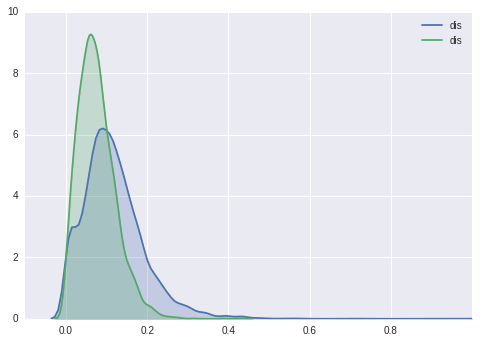

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for a in [sample_qs['dis'][sample_qs['is_duplicate']==0], sample_qs['dis'][sample_qs['is_duplicate']==1]]:
    sns.kdeplot(a,  ax=ax, shade = True)
ax.set_xlim([-0.1, 1])

#sns.kdeplot(sample_qs['dis'][sample_qs['is_duplicate']==0], shade = True)
#plt.show()

plt.show()

# Sentiment

In [19]:
from textblob import TextBlob

def sentiment(question):
    
    pol_sub = [TextBlob(question).sentiment.polarity, 
               TextBlob(question).sentiment.subjectivity]
    return pol_sub           



In [20]:
question1_sent_subj = sample_qs['question1'].apply(sentiment)
sample_qs['polarity1'], sample_qs['subjectivity1'] = zip(*question1_sent_subj)

In [21]:
question1_sent_subj2 = sample_qs['question2'].apply(sentiment)
sample_qs['polarity2'], sample_qs['subjectivity2'] = zip(*question1_sent_subj2)

In [22]:
sample_qs.head()

,id,qid1,qid2,question1,question2,is_duplicate,dis,polarity1,subjectivity1,polarity2,subjectivity2
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0,0.008648,0.00,0.00,0.00,0.000
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0,0.068459,1.00,0.30,0.05,0.775
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0,0.170978,0.50,0.50,1.00,0.300
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1,0.055018,0.25,0.25,0.25,0.250
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1,0.111128,0.00,0.00,0.00,0.000


In [23]:
sample_qs.groupby("is_duplicate").describe()

dis             id    polarity1    polarity2  \
is_duplicate                                                                
0            count  6.265000e+03    6265.000000  6265.000000  6265.000000   
             mean   1.164964e-01  200618.425219     0.127289     0.131872   
             std    7.531203e-02  116402.092921     0.312474     0.319838   
             min   -1.059282e-07     123.000000    -1.000000    -1.000000   
             25%    6.647940e-02  101432.000000     0.000000     0.000000   
             50%    1.065744e-01  199543.000000     0.000000     0.000000   
             75%    1.549666e-01  302048.000000     0.200000     0.245455   
             max    1.000000e+00  404289.000000     1.000000     1.000000   
1            count  3.735000e+03    3735.000000  3735.000000  3735.000000   
             mean   7.596537e-02  202311.231861     0.169028     0.171501   
             std    4.573286e-02  116259.574361     0.362126     0.363832   
             min   -1.127953e-07      85.000000    -1.000000    -1.000000   
             25%    4.252045e-02   99254.000000     0.000000     0.000000   
             50%    6.994835e-02  202784.000000     0.000000     0.000000   
             75%    1.018706e-01  302756.500000     0.333333     0.350000   
             max    4.332188e-01  403724.000000     1.000000     1.000000   

                             qid1           qid2  subjectivity1  subjectivity2  
is_duplicate                                                                    
0            count    6265.000000    6265.000000    6265.000000    6265.000000  
             mean   245780.474860  248007.421069       0.250519       0.257461  
             std    155251.339923  157626.510904       0.292455       0.292595  
             min        87.000000     232.000000       0.000000       0.000000  
             25%    107862.000000  105363.000000       0.000000       0.000000  
             50%    238057.000000  242962.000000       0.119048       0.183333  
             75%    374523.000000  381546.000000       0.500000       0.500000  
             max    537932.000000  537933.000000       1.000000       1.000000  
1            count    3735.000000    3735.000000    3735.000000    3735.000000  
             mean   164413.169210  165315.735743       0.244742       0.250465  
             std    144952.728672  146314.150100       0.286896       0.291283  
             min        77.000000      38.000000       0.000000       0.000000  
             25%     41545.000000   41655.000000       0.000000       0.000000  
             50%    120818.000000  118148.000000       0.125000       0.150000  
             75%    257357.500000  264801.500000       0.450000       0.454545  
             max    536689.000000  536690.000000       1.000000       1.000000

# Different words in each question pair

In [24]:
print(sample_qs['question1'].iloc[30])
print(sample_qs['question2'].iloc[30])

What is your review of Suicide Squad (2016 movie)?
How would you fix Suicide Squad?


In [38]:
def different_words(question_pair):
    
    parsed1 = nlp(question_pair[0])
    parsed2 = nlp(question_pair[1])
    parsed_words1 = {word.lemma_:word.pos_ for word in parsed1 if word.pos_ != 'PUNCT'}
    parsed_words2 = {word.lemma_:word.pos_ for word in parsed2 if word.pos_ != 'PUNCT'}
    diff1 = [(word,pos) for word, pos in parsed_words1.items() if word not in parsed_words2]
    diff2 = [(word,pos) for word, pos in parsed_words2.items() if word not in parsed_words1]
    return len((diff1 + diff2))

In [39]:
different_words(sample_qs[['question1', 'question2']].iloc[30])

11

In [42]:
diff_lens = sample_qs[['question1', 'question2']].apply(different_words, axis = 1)

In [46]:
sample_qs['num_unmatched_words'] = diff_lens
sample_qs.head()

,id,qid1,qid2,question1,question2,is_duplicate,dis,polarity1,subjectivity1,polarity2,subjectivity2,num_unmatched_words
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0,0.008648,0.00,0.00,0.00,0.000,2
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0,0.068459,1.00,0.30,0.05,0.775,8
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0,0.170978,0.50,0.50,1.00,0.300,20
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1,0.055018,0.25,0.25,0.25,0.250,4
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1,0.111128,0.00,0.00,0.00,0.000,6


In [47]:
sample_qs[['is_duplicate', 'num_unmatched_words']].groupby('is_duplicate').describe()

num_unmatched_words
is_duplicate                           
0            count          6265.000000
             mean             12.467358
             std               8.420650
             min               0.000000
             25%               6.000000
             50%              11.000000
             75%              18.000000
             max              59.000000
1            count          3735.000000
             mean              6.982329
             std               4.602834
             min               0.000000
             25%               3.000000
             50%               6.000000
             75%              10.000000
             max              30.000000

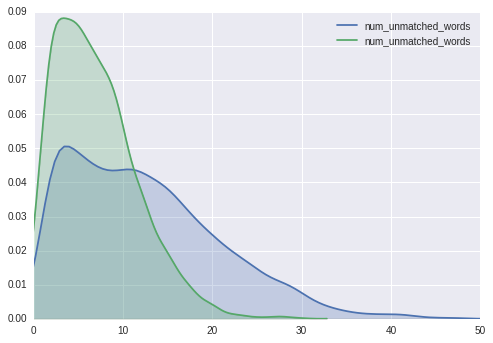

In [56]:
fig, ax = plt.subplots()
for num in [sample_qs['num_unmatched_words'][sample_qs['is_duplicate']==0], sample_qs['num_unmatched_words'][sample_qs['is_duplicate']==1]]:
    sns.kdeplot(num,  ax=ax, shade = True)
ax.set_xlim([0, 50])

#sns.kdeplot(sample_qs['dis'][sample_qs['is_duplicate']==0], shade = True)
#plt.show()

plt.show()
 

In [54]:
from scipy.stats import linregress

linregress(sample_qs['dis'], sample_qs['num_unmatched_words'])


LinregressResult(slope=46.63283612089981, intercept=5.6920852063338652, rvalue=0.41572764499720533, pvalue=0.0, stderr=1.0202905947164829)